# Trying out a full pytorch experiment, with tensorboard, // processing, etc

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
#%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
#%autoreload 2

import numpy as np
import pandas as pd
from src.data import make_dataset
from src.data import read_dataset
from src.data import util

from torchsummary import summary

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = make_dataset.main(reduce_mem_usage=False)

Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/pytho

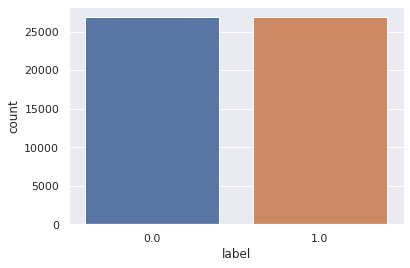

In [3]:
sns.countplot(df["label"])

## Convert data to pytorch types

In [4]:
data_vector = util.get_train_test(df)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train, x_test, y_train, y_test = util.transform_torch(data_vector, device=device)
print(x_train.shape, x_test.shape)

From numpy option does not send to device!


torch.Size([29457, 1, 22050]) torch.Size([24269, 1, 22050])


## Basic 1D convolutional network

[1D conv in Pytorch](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d) 

In the simplest case, the output value of the layer with input size

$$ (N, C_{\text{in}}, L) $$ and output $$ (N, C_{\text{out}}, L_{\text{out}}) $$ can be

$$ (N, C_{\text{in}}, L) $$ and output $$ (N, C_{\text{out}}, L_{\text{out}}) $$ can be
    precisely described as:

$$
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{\text{out}_j}, k)
        \star \text{input}(N_i, k)
$$ 

where $$ \star $$  is the valid "cross-correlation"  operator,
    N is a batch size, C denotes a number of channels,
    L is a length of signal sequence.

# Create Model

In [6]:
class BasicMosquitoNet(nn.Module):
    """A basic 1D conv net.
    We use 1D convolution, followed by max pool, 1D convolution, max pool, FC, FC.
    """
    
    def __init__(self, conv1_out=100, kernel_1=6, stride_1=3, 
                 conv2_out=10, kernel_2=4, stride_2=2):
        """
        conv1: (22050 - 6)/3  + 1 = 7349
        max_pool_1 = floor((Lin + −dilation×(kernel_size−1)−1)/stride_2) + 1
                   = floor(7349-2 /2) + 1 = 3673 + 1 = 3674
        conv2 = (3674 - 4)/2 + 1 = 1836
        max_pool_2 = floor(1836-2 /2) + 1 = 918
        
        """
        super(BasicMosquitoNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_out, 
                               kernel_size=kernel_1, stride=stride_1)
        self.conv2 = nn.Conv1d(in_channels=conv1_out, out_channels=conv2_out, 
                               kernel_size=kernel_2, stride=stride_2)
        self.fc1 = nn.Linear(918*conv2_out, 1)  
        #self.fc1 = nn.Linear(918*conv2_out, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. 
        """
        # Max pooling over a (2, 2) window
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        """
        # We use BCEWithLogitsLoss instead of applying sigmoid here
        # It is better computationally
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [24]:
# create your optimizer
net = BasicMosquitoNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [25]:
summary(net, input_size=x_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 100, 7349]             700
            Conv1d-2             [-1, 10, 1836]           4,010
            Linear-3                    [-1, 1]           9,181
Total params: 13,891
Trainable params: 13,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 5.75
Params size (MB): 0.05
Estimated Total Size (MB): 5.88
----------------------------------------------------------------


# Experiment params

In [26]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 1

version = !python3 --version
version = version[0].split(".")[1]

if int(version) < 7 and params["num_workers"]:
    print("WARNING\n"*10)
    print("Parallel execution only works for python3.7 or above!")
    print("Running in parallel with other versions is not guaranted to work")
    print("See https://discuss.pytorch.org/t/valueerror-signal-number-32-out-of-range-when-loading-data-with-num-worker-0/39615/2")

# Start tensorboard

Run in our terminal: 

`cd notebooks`

`tensorboard --logdir runs`

In [27]:
from torch.utils.tensorboard import SummaryWriter
    
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()

# Create data generator from dataset for batch processing

In [28]:
# Generators
training_set = read_dataset.MosquitoDataset(x_train, y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

testing_set = read_dataset.MosquitoDataset(x_test, y_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **params)

In [48]:
# Simple train function
def train(net, optimizer):
    # Loop over epochs
    last_test_loss = 0
    for epoch in range(max_epochs):
        # Training
        for idx, (local_batch, local_labels) in enumerate(training_generator):
            optimizer.zero_grad()   # zero the gradient buffers
            output = net(local_batch)
            loss = criterion(output, local_labels)
            loss.backward()
            optimizer.step()    # Does the update
            writer.add_scalar("Train Loss Batch", loss.data.item(), idx)

        # Validation
        with torch.set_grad_enabled(False):
            # Transfer to GPU
            #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            cumulative_test_loss = 0
            for idx, (local_batch, local_labels) in enumerate(training_generator):
                output = net(local_batch)
                loss = criterion(output, local_labels)
                writer.add_scalar("Test Loss Batch", loss.data.item(), idx)
                
                cumulative_test_loss += loss.data.item()
            cumulative_test_loss /= idx
            last_test_loss = cumulative_test_loss
            writer.add_scalar("Test Loss Epoch", loss.data.item(), idx)
    
    return last_test_loss
    writer.close()

In [49]:
%%time
train(net, optimizer)

KeyboardInterrupt: 

The first Net had a random loss from the second batch onwards with regards to the training - Let's try something really small first



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [45]:
# new writer
writer = SummaryWriter()

In [50]:
# create your optimizer
net = BasicMosquitoNet(conv1_out=32, conv2_out=4)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
summary(net, input_size=x_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 7349]             224
            Conv1d-2              [-1, 4, 1836]             516
            Linear-3                    [-1, 1]           3,673
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 1.85
Params size (MB): 0.02
Estimated Total Size (MB): 1.95
----------------------------------------------------------------


In [51]:
%%time
train(net, optimizer)

CPU times: user 5min 44s, sys: 5.55 s, total: 5min 49s
Wall time: 1min 26s


0.6939035716912021

In [52]:
# Save the model
torch.save(net.state_dict(), "../models/0.6-BrunoGomesCoelho-test-experiment.pt")